In [293]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest,chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, roc_auc_score
from IPython.display import display

## More Data cleaning

In [294]:
df = pd.read_csv("../data/interim/top200_hiphop_wpopscore.csv")

df.loc[:, 'artist'][1]

' Drake'

In [295]:
df.loc[:, 'artist'] = df.loc[:, 'artist'].str.strip()
df.columns

Index(['stream_count', 'track_id', 'title', 'artist', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'release_date', 'genre', 'release_year', 'has_top_artist_prevyear',
       'score_top_artist_prevyear'],
      dtype='object')

In [296]:
df.drop(columns = ['track_id', 'type', 'id', 'uri', 'track_href', 'analysis_url','release_year', 'genre'], inplace = True)

In [274]:
df.release_date = df.release_date.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").date() if len(x) > 4 else dt.datetime.strptime(x, "%Y").date())

In [297]:
df.describe()

,stream_count,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,has_top_artist_prevyear,score_top_artist_prevyear
count,8.930000e+02,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,4.995726e+06,0.728021,0.618028,5.174692,-6.693037,0.533035,0.201735,0.197179,0.005200,0.186098,0.440364,125.735367,206386.992161,4.004479,0.458007,15.751400
std,2.771975e+06,0.136938,0.153721,3.740871,2.577872,0.499187,0.147256,0.210080,0.038374,0.131296,0.209619,30.373952,54454.708824,0.231930,0.498513,19.170898
min,2.580512e+06,0.216000,0.027900,0.000000,-34.475000,0.000000,0.025100,0.000244,0.000000,0.033500,0.037000,62.839000,35240.000000,1.000000,0.000000,0.000000
25%,3.970058e+06,0.645000,0.524000,1.000000,-7.899000,0.000000,0.076600,0.040200,0.000000,0.105000,0.277000,99.933000,169657.000000,4.000000,0.000000,0.000000
50%,4.517847e+06,0.745000,0.623000,5.000000,-6.373000,1.000000,0.172000,0.121000,0.000000,0.131000,0.430000,129.209000,203267.000000,4.000000,0.000000,0.000000
75%,5.126395e+06,0.829000,0.729000,8.000000,-5.117000,1.000000,0.293000,0.283000,0.000012,0.224000,0.596000,146.992000,237561.000000,4.000000,1.000000,35.000000
max,3.696901e+07,0.974000,0.974000,11.000000,-0.804000,1.000000,0.966000,0.993000,0.740000,0.846000,0.970000,211.842000,487960.000000,5.000000,1.000000,50.000000


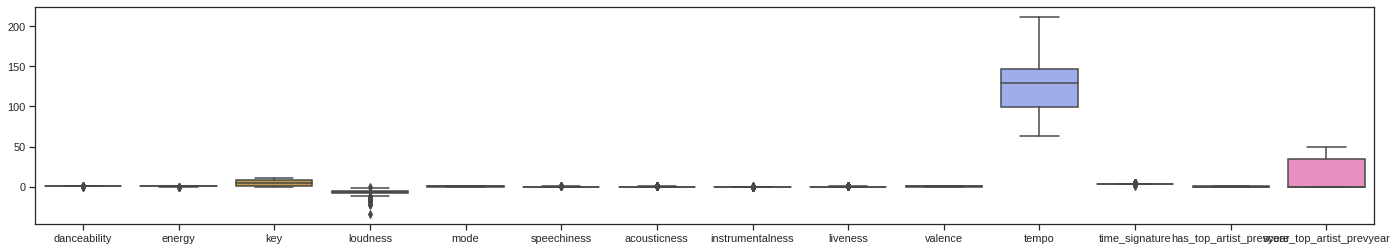

In [276]:
fig, axes = plt.subplots( figsize = (24,4))
sns.boxplot(data = df.drop(columns = ['duration_ms', 'stream_count', 'release_date']));

In [298]:
# Data clipping

def outlier_gone(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return [lower_range,upper_range]

In [299]:
df = df[(df.stream_count > outlier_gone(df.stream_count)[0]) & (df.stream_count < outlier_gone(df.stream_count)[1])]

In [300]:
df = df[(df.duration_ms > outlier_gone(df.duration_ms)[0]) & (df.duration_ms < outlier_gone(df.duration_ms)[1])]

In [301]:
df = df.assign(stream_count = np.log(df.stream_count))
#df = df.assign(speechiness = np.log(df.speechiness))
#df = df.assign(acousticness = np.log(df.acousticness))
#df = df.assign(liveness = np.log(df.liveness))

In [302]:
df.describe()

,stream_count,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,has_top_artist_prevyear,score_top_artist_prevyear
count,805.000000,805.000000,805.00000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,15.293865,0.732732,0.61782,5.132919,-6.690935,0.536646,0.198212,0.193572,0.005402,0.184359,0.440065,126.303458,204396.828571,4.007453,0.454658,15.515528
std,0.183454,0.135029,0.15199,3.736464,2.373915,0.498965,0.141374,0.206006,0.039504,0.129189,0.208543,30.262655,48477.956502,0.205507,0.498249,19.073537
min,14.763498,0.216000,0.02790,0.000000,-22.282000,0.000000,0.025100,0.000244,0.000000,0.033500,0.037000,62.839000,80190.000000,3.000000,0.000000,0.000000
25%,15.182823,0.653000,0.52500,1.000000,-7.881000,0.000000,0.076800,0.039600,0.000000,0.105000,0.277000,100.000000,169397.000000,4.000000,0.000000,0.000000
50%,15.308994,0.746000,0.61900,5.000000,-6.416000,1.000000,0.170000,0.121000,0.000000,0.130000,0.426000,129.987000,202963.000000,4.000000,0.000000,0.000000
75%,15.402811,0.833000,0.72900,8.000000,-5.142000,1.000000,0.291000,0.276000,0.000012,0.222000,0.596000,147.010000,236686.000000,4.000000,1.000000,35.000000
max,15.738945,0.974000,0.97400,11.000000,-0.804000,1.000000,0.937000,0.973000,0.740000,0.846000,0.965000,211.842000,338438.000000,5.000000,1.000000,50.000000


## Split data into train, validation and test sets

In [328]:
# Separate features from target
X, y = df.drop(columns = ['stream_count', 'title', 'artist', 'release_date']), df['stream_count']


In [329]:
# Split data into a train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)
#X_train, y_train = np.array(X_train), np.array(y_train)


In [305]:
# Use difference from mean for features  

X_train = X_train.assign(instrumentalness = X_train.instrumentalness - np.mean(X_train.instrumentalness))
X_train = X_train.assign(danceability = X_train.danceability - np.mean(X_train.danceability))
X_train = X_train.assign(energy = X_train.energy - np.mean(X_train.energy))
X_train = X_train.assign(valence = X_train.valence - np.mean(X_train.valence))
X_train = X_train.assign(tempo = X_train.tempo - np.mean(X_train.tempo))
X_train = X_train.assign(duration_ms = X_train.duration_ms - np.mean(X_train.duration_ms))


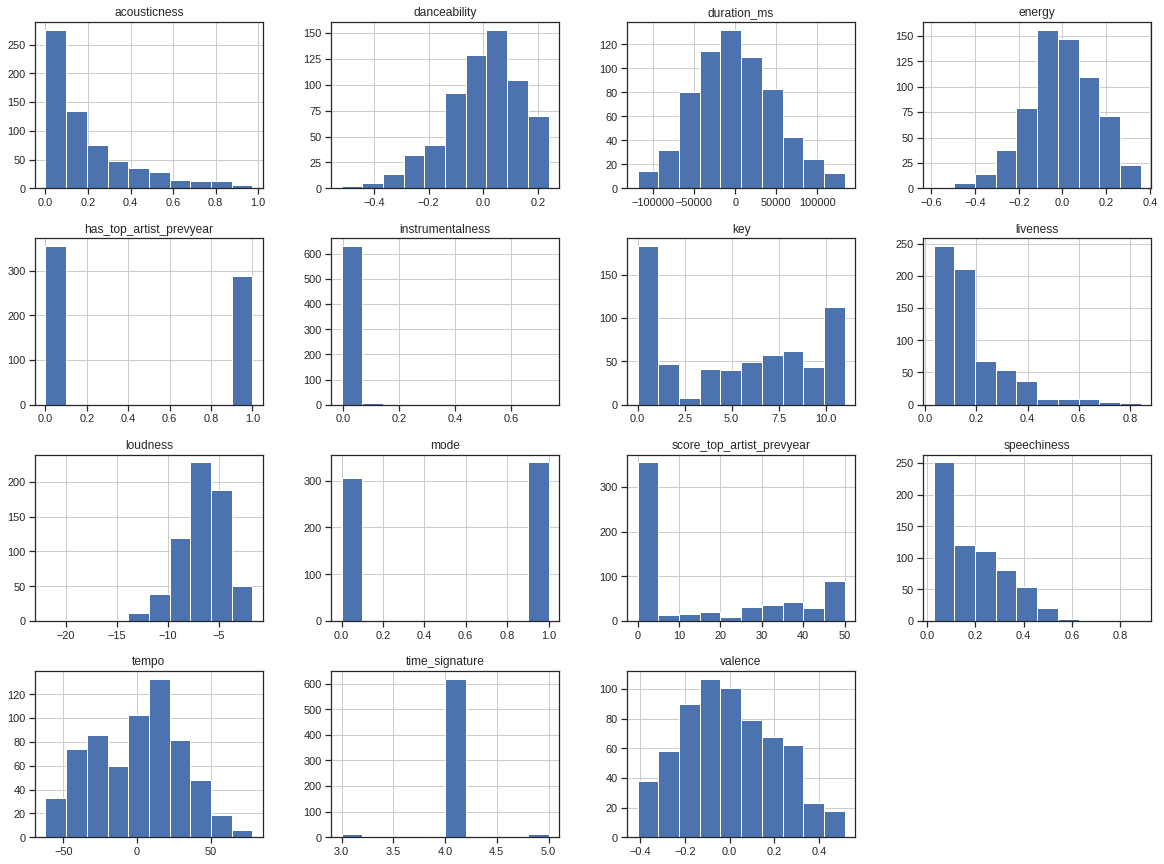

In [306]:
#fig, axes = plt.subplots(4,4, figsize = (18,10))

#counter = 0 
#for row in range(0,4):
#    for col in range(0,4):
#        if counter <= len(column_list):
#            ax = axes[row][col]
#            ax.hist(df[column_list[counter]]) 
#            ax.set_title('{}'.format(column_list[counter]))
#            counter += 1
            
#plt.tight_layout()
#plt.show();


pd.DataFrame.hist(X_train, figsize = [20,15]);

## Data exploration

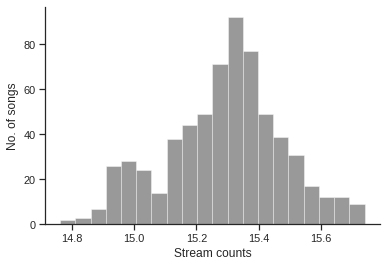

In [307]:
sns.set(style="ticks",font_scale = 1, font = 'Liberation Sans')
ax1 = sns.distplot(y_train, color = "black", kde = False)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax1.set(ylabel = "No. of songs", xlabel='Stream counts')
plt.savefig("hiphop_stream.png")


In [327]:
sorted(X_train.columns)

['duration_ms', 'loudness', 'score_top_artist_prevyear']

Loudness and energy probably shouldn't be included as features together. Likewise for tempo and duration_ms

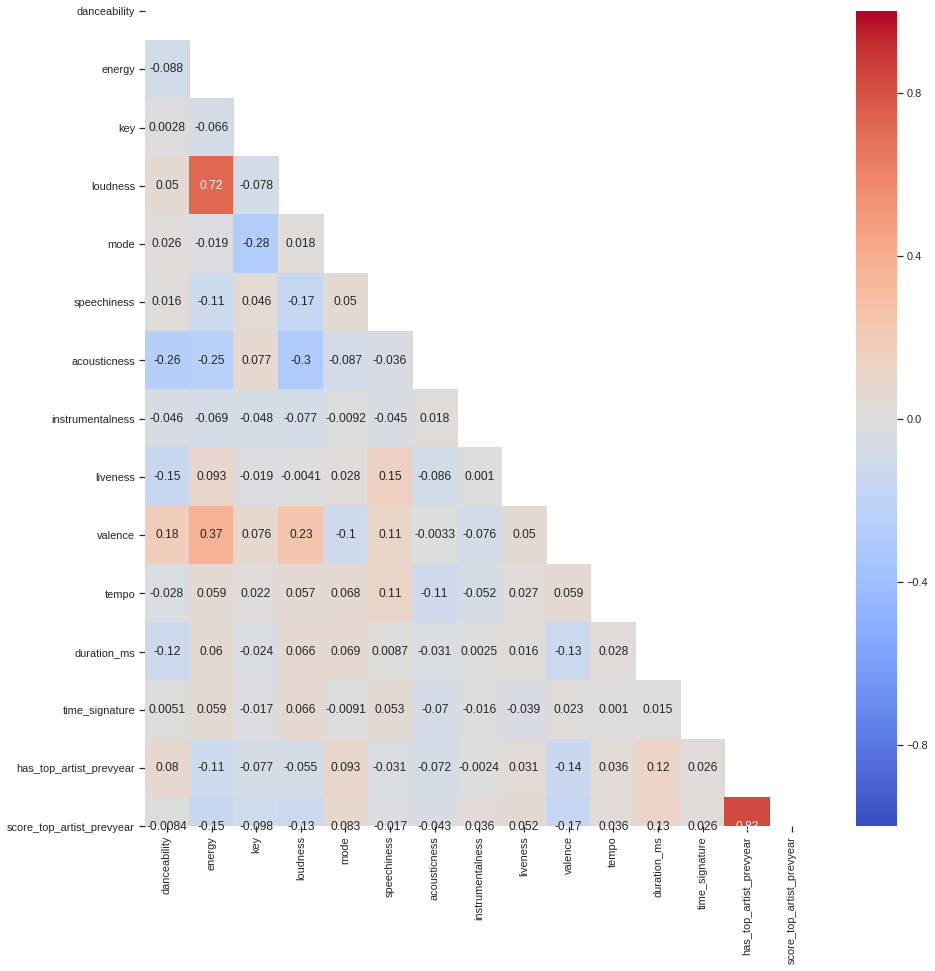

In [309]:
# Check for correlations between features

fig, ax = plt.subplots(figsize = (15,15))
ax.set_ylim(1.5,20)

mask = np.zeros_like(X_train.corr(), dtype = np.bool) # returns an array of zeros with shape of df.corr
mask[np.triu_indices_from(mask)] = True # sets left side of triangle to true
sns.heatmap(X_train.corr(), mask = mask, cmap = 'coolwarm', annot = True, vmin = -1, vmax = 1, ax =ax)

plt.show()

## Scale features 


In [330]:
train = X_train.join(y_train)
train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'has_top_artist_prevyear',
       'score_top_artist_prevyear', 'stream_count'],
      dtype='object')

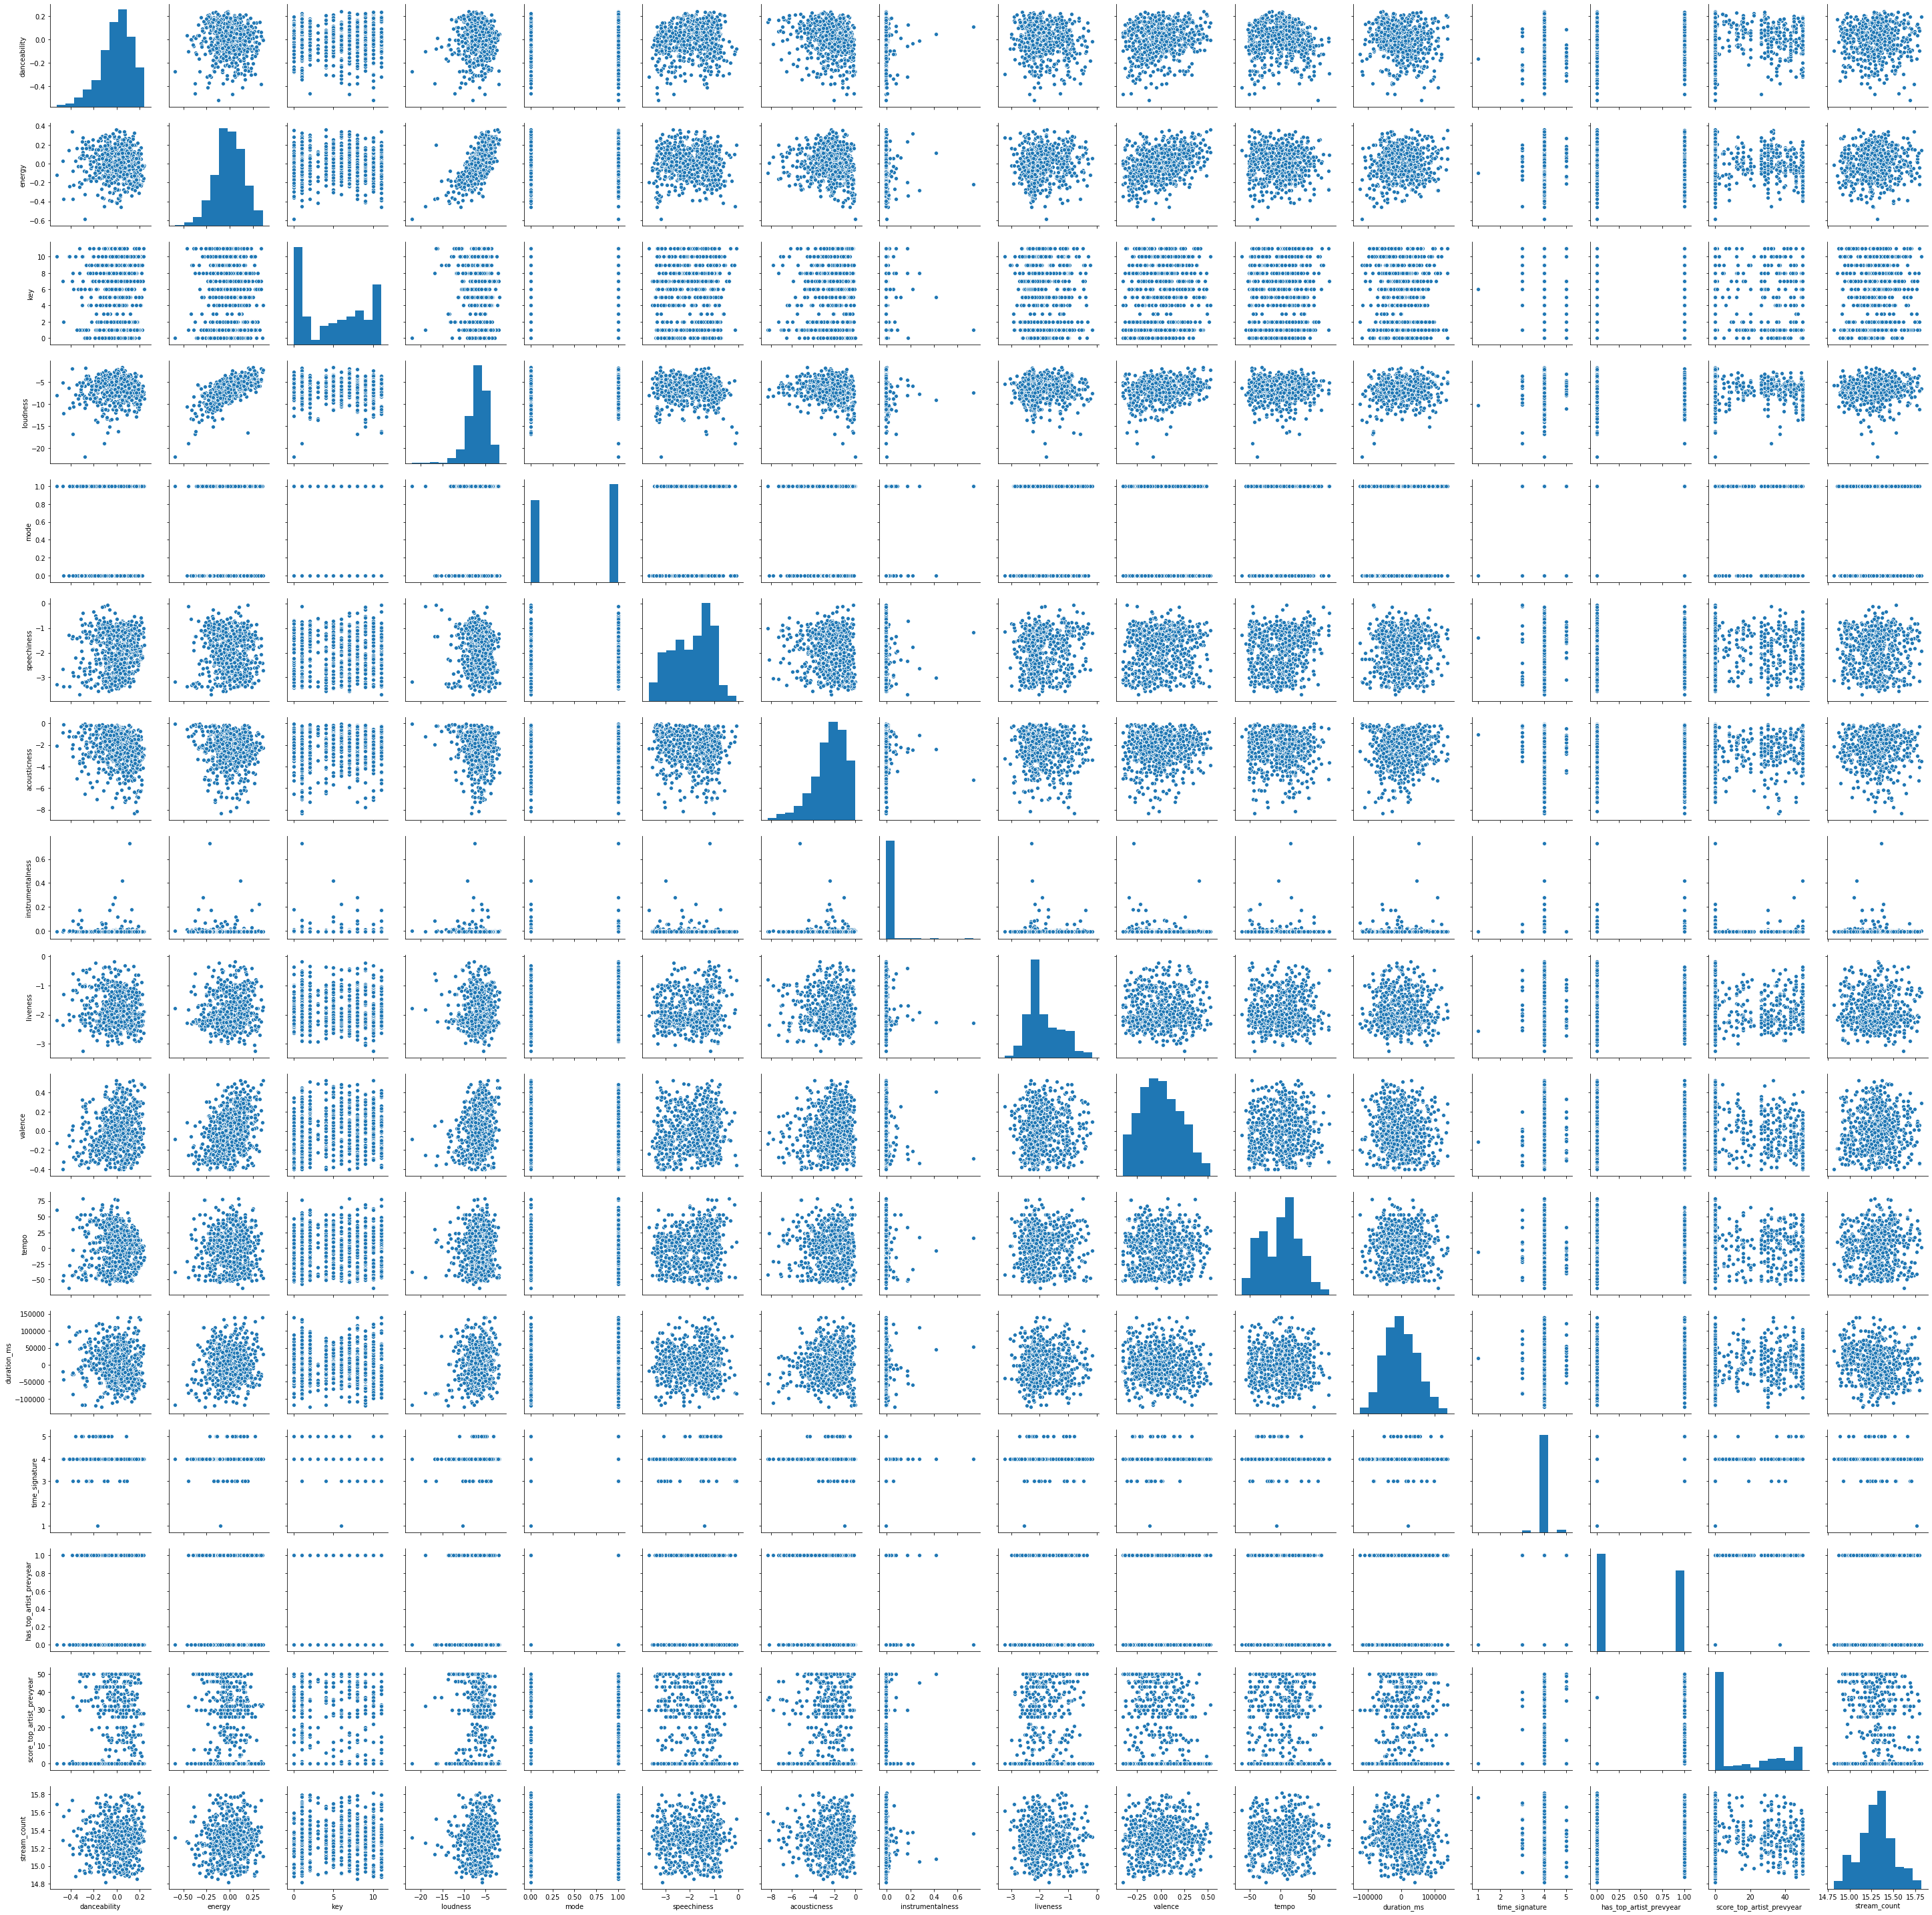

In [22]:
sns.pairplot(train);

## Features selection with 'filter method'

In [311]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

# without energy

y, X = patsy.dmatrices('stream_count ~ danceability + loudness + key + mode + speechiness + acousticness + instrumentalness + liveness + valence + duration_ms + tempo + time_signature + score_top_artist_prevyear' , data = train, return_type = 'dataframe')

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.837
Date:                Wed, 30 Oct 2019   Prob (F-statistic):           5.55e-06
Time:                        01:09:24   Log-Likelihood:                 193.26
No. Observations:                 644   AIC:                            -358.5
Df Residuals:                     630   BIC:                            -296.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    15.5844      0.151    103.376      0.000      15.288      15.880
danceability                 -0.0235      0.058     -0.407      0.684      -0.137       0.090
loudness                      0.0088      0.003      2.588      0.010       0.002       0.016
key                           0.0013      0.002      0.613      0.540      -0.003       0.005
mode                          0.0002      0.015      0.011      0.991      -0.030       0.030
speechiness                   0.0070      0.055      0.128      0.899      -0.100       0.114
acousticness                  0.0547      0.039      1.416      0.157      -0.021       0.130
instrumentalness              0.0574      0.166      0.345      0.730      -0.269       0.384
liveness                     -0.0537      0.058     -0.920      0.358      -0.168       0.061
valence                       0.0328      0.037      0.881      0.379      -0.040       0.106
duration_ms               -7.914e-07    1.5e-07     -5.280      0.000   -1.09e-06   -4.97e-07
tempo                      5.974e-05      0.000      0.246      0.806      -0.000       0.001
time_signature               -0.0589      0.037     -1.611      0.108      -0.131       0.013
score_top_artist_prevyear    -0.0005      0.000     -1.406      0.160      -0.001       0.000
==============================================================================
Omnibus:                        1.716   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.768
Skew:                          -0.123   Prob(JB):                        0.413
Kurtosis:                       2.927   Cond. No.                     1.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [312]:
# Backward filter method

model2 = smf.ols('stream_count ~  loudness + duration_ms + + score_top_artist_prevyear + time_signature ' , data = train)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     11.21
Date:                Wed, 30 Oct 2019   Prob (F-statistic):           8.56e-09
Time:                        01:09:29   Log-Likelihood:                 190.56
No. Observations:                 644   AIC:                            -371.1
Df Residuals:                     639   BIC:                            -348.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    15.5912      0.148    105.370      0.000      15.301      15.882
loudness                      0.0077      0.003      2.519      0.012       0.002       0.014
duration_ms               -8.009e-07   1.47e-07     -5.448      0.000   -1.09e-06   -5.12e-07
score_top_artist_prevyear    -0.0007      0.000     -1.790      0.074      -0.001    6.57e-05
time_signature               -0.0598      0.036     -1.651      0.099      -0.131       0.011
==============================================================================
Omnibus:                        2.022   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                2.092
Skew:                          -0.131   Prob(JB):                        0.351
Kurtosis:                       2.904   Cond. No.                     1.05e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [313]:
# Backwards/forward filter method

#danceability + loudness + key + mode + speechiness + acousticness + instrumentalness + liveness + valence + duration_ms + tempo + time_signature + score_top_artist_prevyear'

model3 = smf.ols('stream_count ~ loudness + duration_ms + score_top_artist_prevyear' , data = train)
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     14.00
Date:                Wed, 30 Oct 2019   Prob (F-statistic):           7.55e-09
Time:                        01:09:35   Log-Likelihood:                 189.19
No. Observations:                 644   AIC:                            -370.4
Df Residuals:                     640   BIC:                            -352.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    15.3496      0.022    710.190      0.000      15.307      15.392
loudness                      0.0073      0.003      2.408      0.016       0.001       0.013
duration_ms               -8.022e-07   1.47e-07     -5.450      0.000   -1.09e-06   -5.13e-07
score_top_artist_prevyear    -0.0007      0.000     -1.844      0.066      -0.001    4.54e-05
==============================================================================
Omnibus:                        1.528   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.593
Skew:                          -0.114   Prob(JB):                        0.451
Kurtosis:                       2.916   Cond. No.                     1.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Features, hyperparameters tuning and model selection

In [331]:
## Scale the data 
std = StandardScaler()
std.fit(X_train.values)

## Get diff from mean for test test. Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)

X_test = X_test.assign(instrumentalness = X_test.instrumentalness - np.mean(X_train.instrumentalness))
X_test = X_test.assign(danceability = X_test.danceability - np.mean(X_train.danceability))
X_test = X_test.assign(energy = X_test.energy - np.mean(X_train.energy))
X_test = X_test.assign(valence = X_test.valence - np.mean(X_train.valence))
X_test = X_test.assign(tempo = X_test.tempo - np.mean(X_train.tempo))
X_test = X_test.assign(tempo = X_test.duration_ms - np.mean(X_train.duration_ms))

X_ts = std.transform(X_test.values)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [332]:
# This is the best alpha value it found 
lasso_model.alpha_

0.01

In [333]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, np.round(lasso_model.coef_,3)))

[('danceability', -0.0),
 ('energy', 0.0),
 ('key', 0.0),
 ('loudness', 0.008),
 ('mode', -0.0),
 ('speechiness', -0.0),
 ('acousticness', 0.0),
 ('instrumentalness', 0.0),
 ('liveness', -0.0),
 ('valence', 0.001),
 ('tempo', 0.0),
 ('duration_ms', -0.03),
 ('time_signature', -0.001),
 ('has_top_artist_prevyear', 0.0),
 ('score_top_artist_prevyear', -0.006)]

In [265]:
# Make predictions on the validation set using the new model
val_set_pred = lasso_model.predict(X_ts)

In [266]:
r2_score(y_test, val_set_pred)

-0.68652136260722

In [355]:
lm = LinearRegression()

X, y = df[['loudness', 'duration_ms', 'score_top_artist_prevyear']], df['stream_count']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)

#std = StandardScaler()

## Add diff from mean as duration_ms feature

X_train = X_train.assign(duration_ms = X_train.duration_ms - np.mean(X_train.duration_ms))

#std.fit(X_train.values)
#X_tr = std.transform(X_train.values)

X_test = X_test.assign(duration_ms = X_test.duration_ms - np.mean(X_train.duration_ms))

#X_ts = std.transform(X_test.values)

lm.fit(X_train, y_train)

lm.score(X_test, y_test)


-1.162640318722774

## Diagnostics

In [356]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, pred, color='black',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res, color = "grey")
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
    plt.savefig("hiphop_residuals.png")

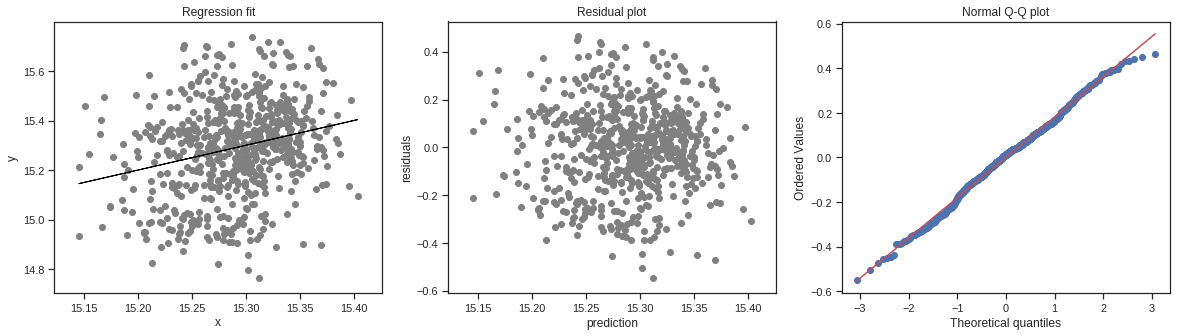

In [357]:
diagnostic_plot(lm.predict(X_train).reshape(-1,1), y_train)


In [292]:
diagnostic_plot(lm.predict(X_ts).reshape(-1,1), y_test)


ValueError: shapes (161,15) and (3,) not aligned: 15 (dim 1) != 3 (dim 0)